In [190]:
# adapted from https://github.com/spmallick/learnopencv/blob/master/OpenPose-Multi-Person/multi-person-openpose.ipynb

import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [191]:
import os

# Set root directory
root_dir = "C:\\Users\\avika\\OneDrive\\Documents\\UAL\\interactive_dance_thesis"
os.chdir(root_dir)

# Check if the current working directory was set correctly
print(os.getcwd())


C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis


In [192]:
device = "gpu" # please change it to "gpu" if the model needs to be run on cuda.

In [193]:
protoFile = "models/openpose_25/pose_deploy.prototxt"
weightsFile = "models/openpose_25/pose_iter_584000.caffemodel"
nPoints = 25

# BODY_25 Keypoints
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
                    'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
                    'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
                    'R-SmallToe', 'R-Heel']

# Defining the limb connections based on the provided keypoints
# The connections are defined as pairs of indices from the keypoints_list

limb_connections = [
    ("Nose", "Neck"),
    ("Neck", "R-Sho"),
    ("R-Sho", "R-Elb"),
    ("R-Elb", "R-Wr"),
    ("Neck", "L-Sho"),
    ("L-Sho", "L-Elb"),
    ("L-Elb", "L-Wr"),
    ("Neck", "MidHip"),
    ("MidHip", "R-Hip"),
    ("R-Hip", "R-Knee"),
    ("R-Knee", "R-Ank"),
    ("MidHip", "L-Hip"),
    ("L-Hip", "L-Knee"),
    ("L-Knee", "L-Ank"),
    ("Nose", "R-Eye"),
    ("R-Eye", "R-Ear"),
    ("Nose", "L-Eye"),
    ("L-Eye", "L-Ear"),
    ("L-Ank", "L-BigToe"),
    ("L-Ank", "L-SmallToe"),
    ("L-Ank", "L-Heel"),
    ("R-Ank", "R-BigToe"),
    ("R-Ank", "R-SmallToe"),
    ("R-Ank", "R-Heel")
]


# BODY_25 Pose Pairs
POSE_PAIRS = [[1,0], [1,2], [1,5], [2,3], [3,4], [5,6], [6,7], [1,8], [8,12], 
              [8,9], [9,10], [12,13], [13,14], [1,15], [1,16], [0,15], [0,16], 
              [15,17], [16,18], [14,21], [14,19], [19,20], [10,23], [10,22], 
              [22,23]]

# I'm assuming PAF indices based on the order in POSE_PAIRS, but this might need adjustment.
mapIdx = [[0,1], [2,3], [4,5], [6,7], [8,9], [10,11], [12,13], [14,15], [16,17],
          [18,19], [20,21], [22,23], [24,25], [26,27], [28,29], [30,31], [32,33], 
          [34,35], [36,37], [38,39], [40,41], [42,43], [44,45], [46,47], [48,49]]

# Colors for keypoints, added random colors for the 7 new keypoints.
colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
          [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
          [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0],
          [255,255,0], [200,0,200], [0,200,200], [255,100,100], [100,255,100], 
          [100,100,255], [255,50,50]]


In [194]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


## Use the following equation for finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

In the above equation:

L is the PAF;

d is the vector joining two joints;

p is the interpolated point between two joints;

It is implemented using the dot product between the PAF and the vector $d_{ij}$

In [195]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.05
    conf_th = 0.6
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs


In [196]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, nPoints = nPoints):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, nPoints+1))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(nPoints+1)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [197]:
image1 = cv2.imread("data/test_pose.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

#### Load the network and pass the image through the network

In [198]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Using GPU device
Time Taken = 0.8185820579528809


#### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 1199.5, 827.5, -0.5)

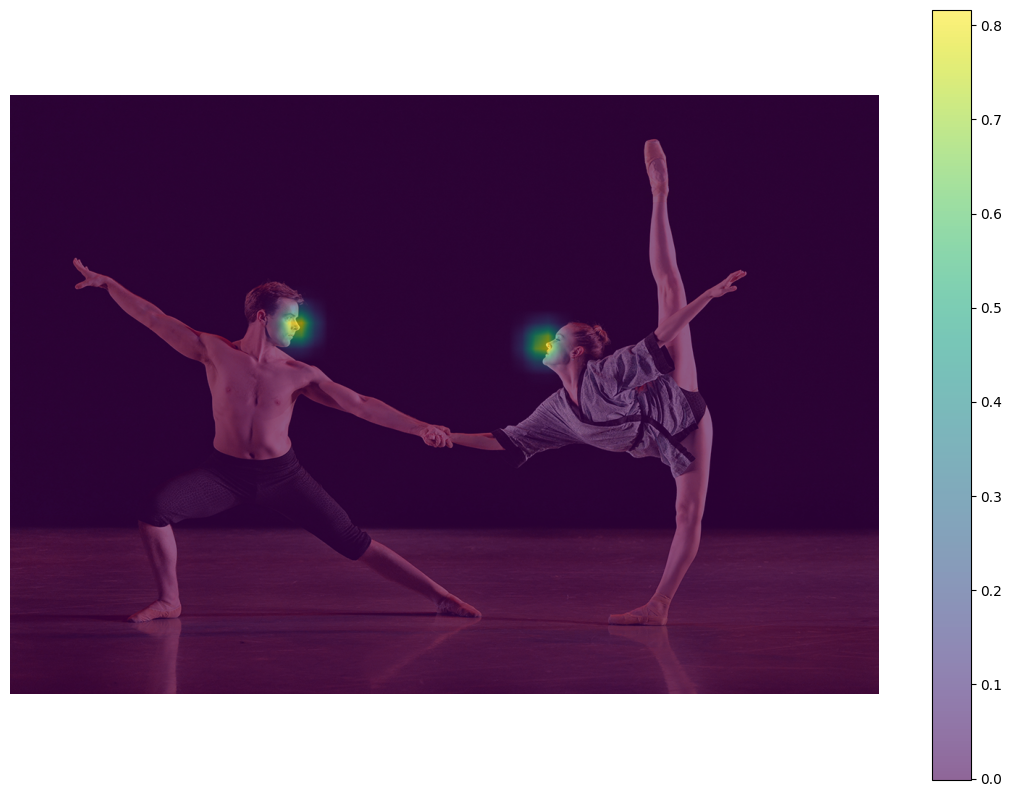

In [199]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [200]:
detected_keypoints = []
keypoints_body_map = {}

keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_body_map[keypointsMapping[part]] = keypoints
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


Keypoints - Nose : [(742, 350, 0.8085921), (401, 315, 0.81208694)]
Keypoints - Neck : [(795, 405, 0.72365195), (331, 368, 0.8934284)]
Keypoints - R-Sho : [(759, 440, 0.6873898), (277, 351, 0.846936)]
Keypoints - R-Elb : [(671, 477, 0.7896595), (189, 298, 0.6890399)]
Keypoints - R-Wr : [(599, 476, 0.6610538), (134, 260, 0.8994186), (887, 135, 0.11509893)]
Keypoints - L-Sho : [(815, 386, 0.6820082), (386, 386, 0.72099537)]
Keypoints - L-Elb : [(475, 423, 0.78877443), (904, 332, 0.7562283)]
Keypoints - L-Wr : [(563, 458, 0.8233591), (958, 278, 0.8217502)]
Keypoints - MidHip : [(331, 530, 0.7618312), (904, 458, 0.43214893)]
Keypoints - R-Hip : [(295, 530, 0.685025), (868, 459, 0.2261792)]
Keypoints - R-Knee : [(205, 567, 0.7765771)]
Keypoints - R-Ank : [(223, 693, 0.793946), (887, 134, 0.12010247)]
Keypoints - L-Hip : [(368, 530, 0.67512774), (939, 458, 0.5738643)]
Keypoints - L-Knee : [(474, 620, 0.8168826), (938, 567, 0.7014341), (904, 261, 0.18905109)]
Keypoints - L-Ank : [(886, 710, 0.

In [201]:
keypoints_body_map

{'Nose': [(742, 350, 0.8085921), (401, 315, 0.81208694)],
 'Neck': [(795, 405, 0.72365195), (331, 368, 0.8934284)],
 'R-Sho': [(759, 440, 0.6873898), (277, 351, 0.846936)],
 'R-Elb': [(671, 477, 0.7896595), (189, 298, 0.6890399)],
 'R-Wr': [(599, 476, 0.6610538),
  (134, 260, 0.8994186),
  (887, 135, 0.11509893)],
 'L-Sho': [(815, 386, 0.6820082), (386, 386, 0.72099537)],
 'L-Elb': [(475, 423, 0.78877443), (904, 332, 0.7562283)],
 'L-Wr': [(563, 458, 0.8233591), (958, 278, 0.8217502)],
 'MidHip': [(331, 530, 0.7618312), (904, 458, 0.43214893)],
 'R-Hip': [(295, 530, 0.685025), (868, 459, 0.2261792)],
 'R-Knee': [(205, 567, 0.7765771)],
 'R-Ank': [(223, 693, 0.793946), (887, 134, 0.12010247)],
 'L-Hip': [(368, 530, 0.67512774), (939, 458, 0.5738643)],
 'L-Knee': [(474, 620, 0.8168826),
  (938, 567, 0.7014341),
  (904, 261, 0.18905109)],
 'L-Ank': [(886, 710, 0.7298584),
  (599, 693, 0.72984135),
  (887, 134, 0.12055421)],
 'R-Eye': [(385, 314, 0.87604684)],
 'L-Eye': [(744, 333, 0.79209

In [202]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([[26.        , 30.        ,  0.37917301],
       [27.        , 29.        ,  0.68833971],
       [28.        , 29.        ,  0.82272754]]), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), array([[29.        , 43.        ,  0.21148819],
       [30.        , 44.        ,  0.44851525]]), array([], shape=(0, 3), dtype=float

In [203]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

In [204]:
keypoints_body_map

{'Nose': [(742, 350, 0.8085921), (401, 315, 0.81208694)],
 'Neck': [(795, 405, 0.72365195), (331, 368, 0.8934284)],
 'R-Sho': [(759, 440, 0.6873898), (277, 351, 0.846936)],
 'R-Elb': [(671, 477, 0.7896595), (189, 298, 0.6890399)],
 'R-Wr': [(599, 476, 0.6610538),
  (134, 260, 0.8994186),
  (887, 135, 0.11509893)],
 'L-Sho': [(815, 386, 0.6820082), (386, 386, 0.72099537)],
 'L-Elb': [(475, 423, 0.78877443), (904, 332, 0.7562283)],
 'L-Wr': [(563, 458, 0.8233591), (958, 278, 0.8217502)],
 'MidHip': [(331, 530, 0.7618312), (904, 458, 0.43214893)],
 'R-Hip': [(295, 530, 0.685025), (868, 459, 0.2261792)],
 'R-Knee': [(205, 567, 0.7765771)],
 'R-Ank': [(223, 693, 0.793946), (887, 134, 0.12010247)],
 'L-Hip': [(368, 530, 0.67512774), (939, 458, 0.5738643)],
 'L-Knee': [(474, 620, 0.8168826),
  (938, 567, 0.7014341),
  (904, 261, 0.18905109)],
 'L-Ank': [(886, 710, 0.7298584),
  (599, 693, 0.72984135),
  (887, 134, 0.12055421)],
 'R-Eye': [(385, 314, 0.87604684)],
 'L-Eye': [(744, 333, 0.79209

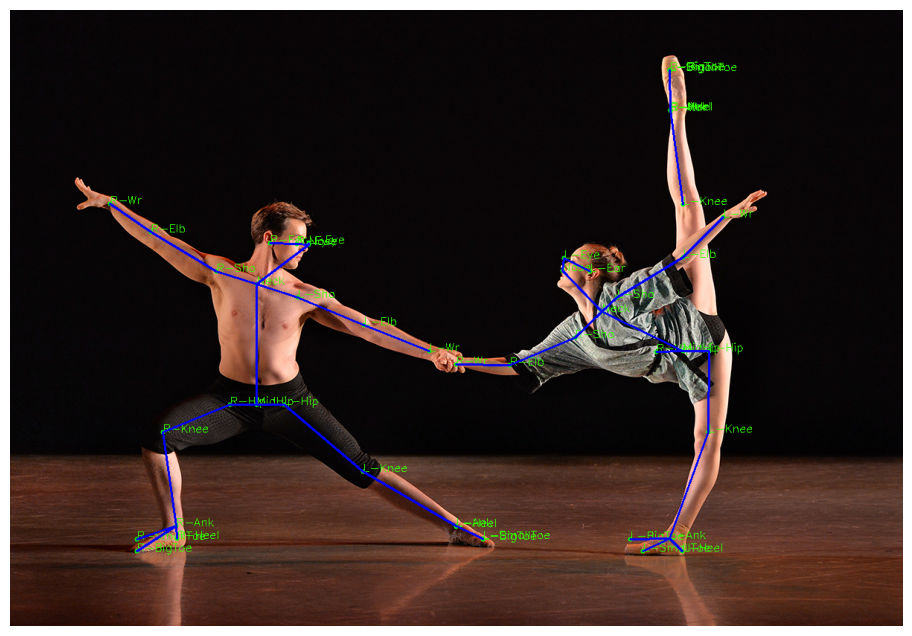

In [205]:
# Adjusting the visualization function to connect keypoints that are likely to belong to the same person

from collections import defaultdict

frameClone = image1.copy()

def create_skeletons(start_name, end_name ):
    """ Assign keypoints to person. Closest points likely to be from the same person. But same bodypart cannot be connected to the the same bodypart twice"""
    distance_map = defaultdict(dict)
    i = 0
    for start_pt in keypoints_body_map[start_name]:
        k=0
        for end_pt in keypoints_body_map[end_name]:
            distance = np.sqrt((start_pt[0] - end_pt[0])**2 + (start_pt[1] - end_pt[1])**2)
            distance_map[(f"{start_name}_{i}", f"{end_name}_{k}")] = {'start_pt': start_pt, 'end_pt': end_pt, 'distance': distance}
            k=k+1
        i = i + 1


    # pick closest distance, but if there are multiple people same bodypart cannot be connected to the same bodypart twice
    # First, we'll initialize our resultant dictionary as empty
    resultant_dict = {}

    # min number of parts, so unique connections only
    num_min_parts = min(len(keypoints_body_map[start_name]), len(keypoints_body_map[end_name])) 
    
    # We'll continue picking pairs until we've picked half the number of pairs in the original data
    while len(resultant_dict) < num_min_parts :
        # Sorting the data by distance and picking the pair with the lowest distance
        sorted_data = sorted(distance_map.items(), key=lambda x: x[1]['distance'])
        
        current_pick = sorted_data[0]
        
  
        # Adding the picked pair to the resultant dictionary
        resultant_dict[current_pick[0]] = current_pick[1]
        
        # Removing the picked pair from the original data
        del distance_map[current_pick[0]]
        
        # Removing entries containing the same body parts as the current pick
        keys_to_remove = [key for key in distance_map if current_pick[0][0] in key or current_pick[0][1] in key]
    

        for key in keys_to_remove:
            del distance_map[key]
            
        
    return resultant_dict

def refined_visualize_skeleton(image, keypoints_dict, connections):
    img = image.copy()
    
    # Draw keypoints
    for k,v in keypoints_dict.items():
        for idx, val in enumerate(v):
            x,y,conf = val
        
            cv2.circle(img, (int(x), int(y)), 3, (0, 255, 0), -1)
            cv2.putText(img, f"{k}", ((int(x)), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 50),1)
            
    
    
    # Draw limb connections
    for start_name, end_name in connections:
        connections_dict = create_skeletons(start_name, end_name)
        for k,v in connections_dict.items():
            start_pt = v['start_pt']
            end_pt = v['end_pt']
            cv2.line(img, (int(start_pt[0]), int(start_pt[1])), (int(end_pt[0]), int(end_pt[1])), (255, 0, 0), 2)
        
    
    return img

# Testing the refined visualization on a blank canvas
visualized_img = refined_visualize_skeleton(frameClone, keypoints_body_map, limb_connections)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(visualized_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
